**Question 1**

In [22]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn

In [2]:
#https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mnist_train=datasets.MNIST('mnist',
train=True,
download=True,
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
]))

mnist_test=datasets.MNIST('mnist',
train=False,
download=True,
transform=transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
]))

train_len = len(mnist_train)
test_len = len(mnist_test)
epochs = 20
units = 1024         
input1 = 28             
input2 = 28    
output1 = 10
stop_rounds = 10             

class RegNet(nn.Module):
    def __init__(self,input1,input2):
        super(RegNet,self).__init__()
        self.input = nn.Linear(input1*input2, units)
        self.hide1 = nn.Linear(units, units)
        self.hide2 = nn.Linear(units, units)
        self.hide3 = nn.Linear(units, units)
        self.hide4 = nn.Linear(units, units)
        #self.hide5 = nn.Linear(units, units)
        self.output = nn.Linear(units, output1)
              
    def forward(self, network):
        network = self.input(network)
        network = F.relu(network)
        network = self.hide1(network)
        network = F.relu(network)
        network = self.hide2(network)
        network = F.relu(network)
        network = self.hide3(network)
        network = F.relu(network)
        network = self.hide4(network)
        network = F.relu(network)
        #network = self.hide5(network)
        #network = F.relu(network)
        network = self.output(network) 
        return network

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
def weight_data(m):
  classname = m.__class__.__name__
  if classname.find('Linear') != -1:
      n = m.in_features
      y = 1.0/np.sqrt(n)
      #m.weight.data.uniform_(0.0, 1.0)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

def train_neural_network(model,train_dataset,test_dataset,epochs,batch_size,stop_rounds,
                         lr,verbose,activation,assess,input1,input2,dev):
  
  test_len = len(test_dataset)
  initial=1
  stop = 0
  top = 0
  rounds = 0
  stop = False
  max = 98

  train_iterate = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  test_iterate = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_len, shuffle=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  final_output = dict()
  
  #while initial <= epochs:
  while ((initial <= epochs)and(stop==False)):
    for img, label in train_iterate:  
      img_reshape = img.reshape(-1,input1*input2).to(dev)
      label = label.to(dev)
      output_img = model(img_reshape)
      loss = activation(output_img, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      test_img,test_label = next(iter(test_iterate))
      test_img_reshape = test_img.reshape(-1, input1*input2).to(dev)
      test_label_accuracy = model.forward(test_img_reshape).argmax(1).cpu().numpy()
      accuracy = assess(test_label.numpy(),test_label_accuracy)

      if(accuracy > top):
        rounds = 0
        top = accuracy
        best_prediction = test_label_accuracy
        best_state_dict = model.state_dict()
        final_output["train_iterate"] = train_iterate
        final_output["test_img"] = test_img
        final_output["test_label"] = test_label
        final_output["model"] = model
        final_output["best_prediction"] = best_prediction
        final_output["top"] = top
        torch.save(model, 'top_mnist.pt')
      
      else:
        rounds += 1
        if(rounds == stop_rounds):
          stop = True

    #if(((initial%5==0)|(stop==True))&(verbose==True)):
      # print("Current_epoch:"+str(initial))
      # print('Accuracy: '+str(accuracy))

    print("Current_epoch:"+str(initial))
    print('Accuracy: '+str(accuracy))

    initial += 1

    
  return(final_output)

In [ ]:
from sklearn.metrics import accuracy_score

model1 = RegNet(input1=input1,input2=input2).to(dev)
model1.apply(weight_data)
final_output = train_neural_network(model=model1,
               train_dataset=mnist_train,
               test_dataset=mnist_test,
               epochs=epochs,
               batch_size=4096,
               stop_rounds = stop_rounds,
               lr=0.001,
               verbose=True,
               activation=nn.CrossEntropyLoss(),
               assess=accuracy_score,
               input1=input1,
               input2=input2,
               dev=dev)
train_iterate = final_output["train_iterate"] 
test_img = final_output["test_img"] 
test_label = final_output["test_label"]
best_model = final_output["model"] 
test_label_accuracy = final_output["best_prediction"]

Current_epoch:1
Accuracy: 0.8003
Current_epoch:2
Accuracy: 0.9092
Current_epoch:3
Accuracy: 0.9467
Current_epoch:4
Accuracy: 0.9621
Current_epoch:5
Accuracy: 0.9688
Current_epoch:6
Accuracy: 0.974
Current_epoch:7
Accuracy: 0.9766
Current_epoch:8
Accuracy: 0.9788
Current_epoch:9
Accuracy: 0.9805
Current_epoch:10
Accuracy: 0.9785
Current_epoch:11
Accuracy: 0.9815
Current_epoch:12
Accuracy: 0.985
Current_epoch:13
Accuracy: 0.9836
Current_epoch:14
Accuracy: 0.9842
Current_epoch:15
Accuracy: 0.9835
Current_epoch:16
Accuracy: 0.9834
Current_epoch:17
Accuracy: 0.9844
Current_epoch:18
Accuracy: 0.9812
Current_epoch:19
Accuracy: 0.9796
Current_epoch:20
Accuracy: 0.9816


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#torch.save(model, "model_1.pth")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if __name__ == '__main__':


torch.Size([983, 28, 28])
torch.Size([1142, 28, 28])
torch.Size([1036, 28, 28])
torch.Size([1019, 28, 28])
torch.Size([977, 28, 28])
torch.Size([883, 28, 28])
torch.Size([958, 28, 28])
torch.Size([1022, 28, 28])
torch.Size([967, 28, 28])
torch.Size([1013, 28, 28])


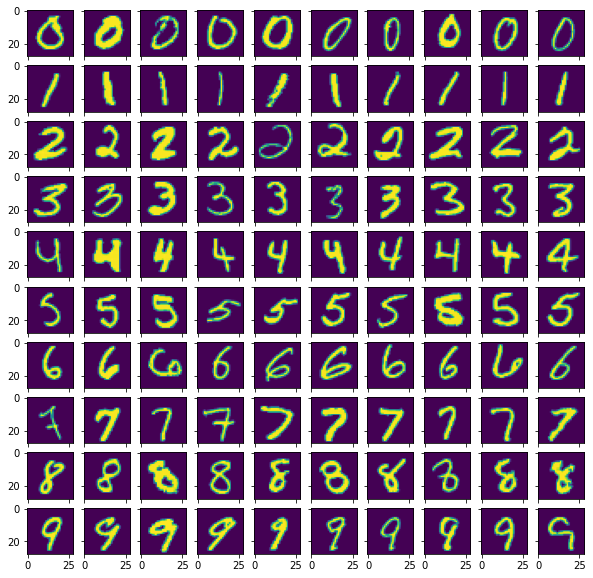

In [ ]:
#test_label_accuracy = final_output["test_label_accuracy"]
fig, axes = plt.subplots(10,10, 
                         figsize=(10,10),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect='equal'))
for item in range(0,10):
    count = np.sum(test_label_accuracy==item)
    prob = np.where(test_label_accuracy==item)
    test_img_1 = test_img[prob,:,:].reshape([count,input1,input2])
    test_label_1 = test_label[prob]
    print(test_img_1.shape)
    for k in range(0,10):
      ax = axes[item,k]
      img = test_img_1[k]
      ax.imshow(img)
plt.show()

In [ ]:
units = 1024
output2 = 10
class RegNet2(nn.Module):
    def __init__(self):
        super(RegNet2,self).__init__()
        self.input = nn.Linear(input1*input2, units)
        self.hide1 = nn.Linear(units, units)
        self.hide2 = nn.Linear(units, units)
        self.hide3 = nn.Linear(units, units)
        self.hide4 = nn.Linear(units, units)
        #self.hide5 = nn.Linear(units, units)
        self.output = nn.Linear(units, output2)
        #self.dropout = nn.Dropout(0.5)

        
    def forward(self, network):
        network = self.input(network)
        final_res = dict()
        network = F.relu(network)
        #final_res["input"]= self.dropout(network)
        final_res["input"]= network
        #network = final_res["input"]
        network = self.hide1(network)
        network = F.relu(network)
        #final_res["hide1"] = self.dropout(network)
        final_res["hide1"] = network
        #network = final_res["hide1"]
        network = self.hide2(network)
        network = F.relu(network)
        #final_res["hide2"]= self.dropout(network)
        final_res["hide2"]= network
        #network = final_res["hide2"]
        network = self.hide3(network)
        network = F.relu(network)
        #final_res["hide3"]= self.dropout(network)
        final_res["hide3"]= network
        #network = final_res["hide3"]
        network = self.hide4(network)
        network = F.relu(network)
        #final_res["hide4"]= self.dropout(network)
        final_res["hide4"]= network
        #network = final_res["hide4"]
        #network = self.hide5(network)
        #network = F.relu(network)
        #final_res["hide5"]= self.dropout(network)
        #network = final_res["hide5"]
        network = self.output(network)
        #final_res["output"]=F.softmax(network, dim=1)
        #final_res["output"] = self.dropout(network)
        final_res["output"] = network
        #network = final_res["output"]

        return final_res

In [ ]:
model2 = RegNet2().to(dev)
model2.load_state_dict(best_model.state_dict())
test_img_reshape = test_img.reshape(-1, input1*input2).to(dev)
final_res = model2.forward(test_img_reshape)
    #test_label_accuracy = model.forward(test_img_reshape).argmax(1).cpu().numpy()
print(final_res["hide4"])
second_last = final_res["hide4"]
selected = np.random.choice(np.array(range(0,test_len)),1000,replace=False)
output_x = np.random.choice(np.array(range(0,units)),output2,replace=False)
second_last_1 = second_last[selected,:][:,output_x]
second_last_label = F.softmax(second_last_1,dim=1).argmax(1).cpu().numpy()
#print(l5_labels_pred.shape)
#print(np.unique(l5_labels_pred,return_counts=True))

tensor([[0.0000, 2.6136, 3.4206,  ..., 0.0000, 0.0000, 8.5060],
        [0.0000, 0.0000, 0.2585,  ..., 0.0000, 0.1515, 0.9984],
        [0.5392, 2.4775, 0.2745,  ..., 0.0000, 1.9583, 1.4252],
        ...,
        [0.0000, 0.0000, 0.4609,  ..., 0.0000, 1.7568, 0.2806],
        [1.3507, 0.0000, 0.0000,  ..., 0.0000, 1.5755, 0.0000],
        [0.0000, 0.0000, 1.1293,  ..., 0.0000, 1.8438, 0.7760]],
       device='cuda:0', grad_fn=<ReluBackward0>)


torch.Size([77, 28, 28])
torch.Size([96, 28, 28])
torch.Size([0, 28, 28])
torch.Size([181, 28, 28])
torch.Size([244, 28, 28])
torch.Size([0, 28, 28])
torch.Size([174, 28, 28])
torch.Size([0, 28, 28])
torch.Size([228, 28, 28])
torch.Size([0, 28, 28])


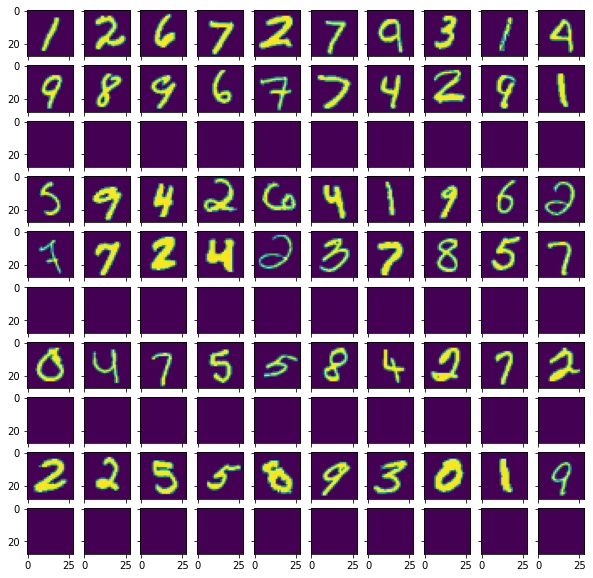

In [ ]:
fig, axes = plt.subplots(10,10, 
                         figsize=(10,10),
                         sharex=True, sharey=True,
                         subplot_kw=dict( aspect='equal'))
for item in range(0,10):
  #val_images_curr = test_img[np.where(l5_labels_pred==i),:,:].reshape([np.sum(l5_labels_pred==i),input1,input2])
  #val_labels_curr = val_labels[np.where(l5_labels_pred==i)]
  count = np.sum(second_last_label==item)
  prob = np.where(second_last_label==item)
  test_img_2 = test_img[prob,:,:].reshape([count,input1,input2])
  test_label_2 = test_label[prob]
  print(test_img_2.shape)
  for k in range(0,10):
    ax = axes[item,k]
    # plot image on subplot
    try:
      image = test_img_2[k]
      label = str(test_label_2[k].item())
    except:
      image = np.zeros((input1,input2))
    ax.imshow(image)
plt.show()

**Reasoning**: For few layers, it's all blank images that means the prediction for those is zero. So, compared to 1.3, in 1.4 when we are applying for the second to last layer it's not all the instances are being covered.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

test_labels_rand = test_label[selected]

def tsne(test_img_rand, units):
  test_tsne_img = TSNE(n_components=2, random_state = 42).fit_transform(test_img_rand.reshape([1000,units]))

  dataframe = pd.DataFrame(test_tsne_img)
  dataframe.columns = ["tsne_x","tsne_y"]
  dataframe["labels"] = test_labels_rand.numpy()
  dataframe["labels"] = dataframe["labels"].apply(lambda x:""+str(x))

  dataframe_center = dataframe.groupby("labels").agg({"tsne_x":"mean","tsne_y":"mean"}).reset_index()
  dataframe_center["labels"] = dataframe_center["labels"].apply(lambda x:int(x[-1]))
  dataframe_center.sort_values(by="labels",ascending=True,inplace=True)

  plt.figure(figsize=(10,10))
  sns.scatterplot(x="tsne_x",y="tsne_y",hue="labels",data=dataframe)
  center = dataframe_center.values
  for i in range(0,10):
    plt.annotate(str(center[i,0]), (center[i,1],center[i,2]),horizontalalignment='center', verticalalignment='center', size=20, color='b')

def pca(test_img_rand, units):
  test_pca_img = PCA(n_components=2).fit_transform(test_img_rand.reshape([1000,units]))
  dataframe = pd.DataFrame(test_pca_img)
  dataframe.columns = ["pca_x","pca_y"]
  dataframe["frames"] = test_labels_rand.numpy()
  dataframe["frames"] = dataframe["frames"].apply(lambda x:""+str(x))
  dataframe_center = dataframe.groupby("frames").agg({"pca_x":"mean","pca_y":"mean"}).reset_index()
  dataframe_center["frames"] = dataframe_center["frames"].apply(lambda x:int(x[-1]))
  dataframe_center.sort_values(by="frames",ascending=True,inplace=True)

  plt.figure(figsize=(10,10))
  sns.scatterplot(x="pca_x",y="pca_y",hue="frames",data=dataframe)
  center = dataframe_center.values
  for i in range(0,10):
    plt.annotate(str(center[i,0]), (center[i,1],center[i,2]), horizontalalignment='center', verticalalignment='center', size=20, color='b')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


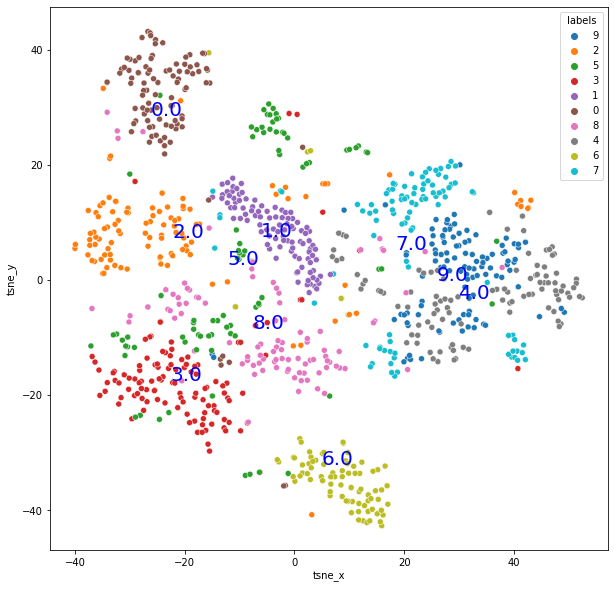

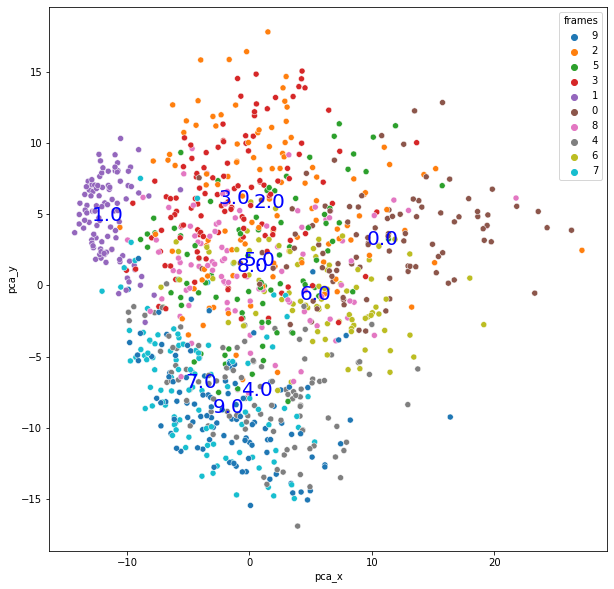

In [ ]:
test_img_rand = test_img[selected]
tsne(test_img_rand, input1*input2)
pca(test_img_rand, input1*input2)

**Reasoning**: I suppose these raw image samples are not so easy to classify. With the plot we can say that the classes are being overlapped and not meaningfully and efficiently classifed. 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


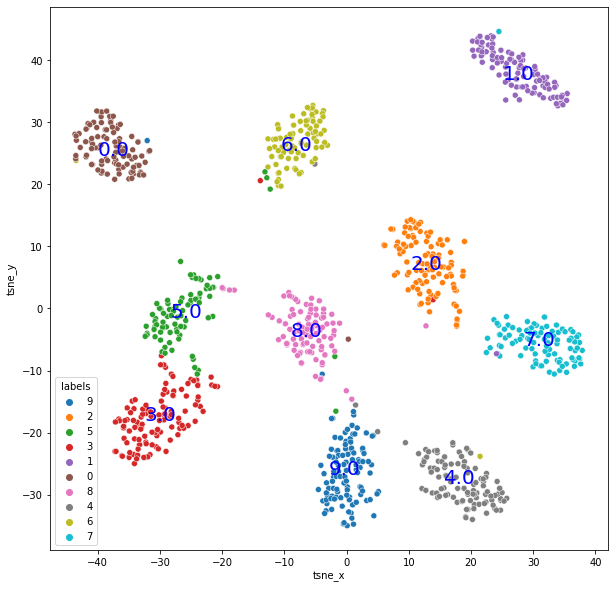

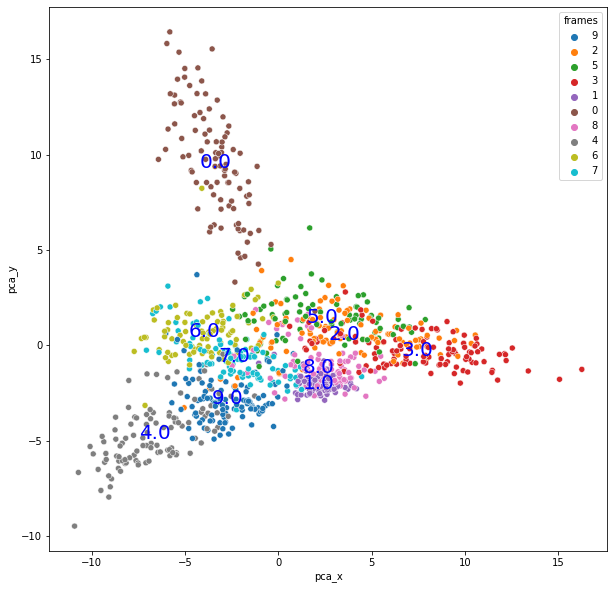

In [ ]:
hide1 = final_res["hide1"]
hide1_main = hide1[selected,:].detach().cpu().numpy()
tsne(hide1_main, 1024)
pca(hide1_main, 1024)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

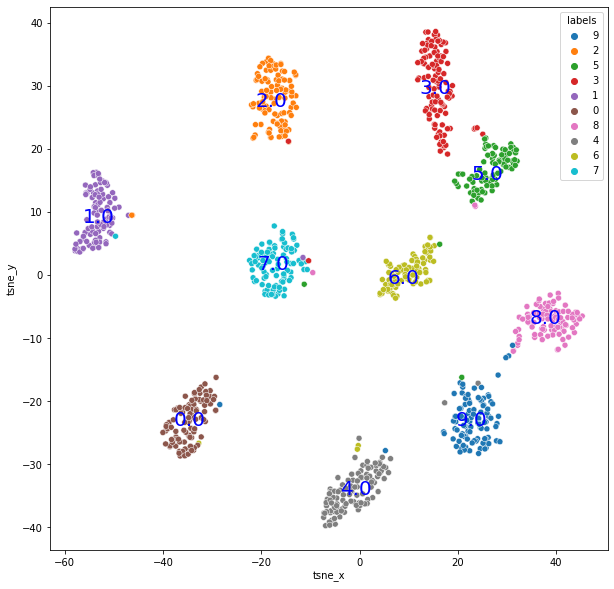

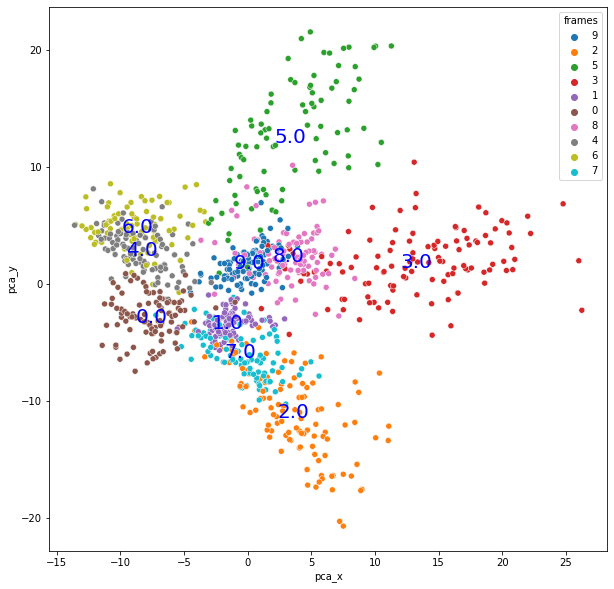

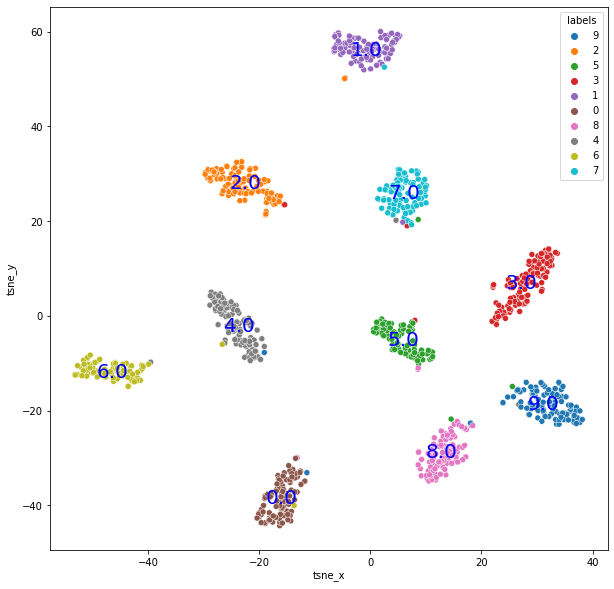

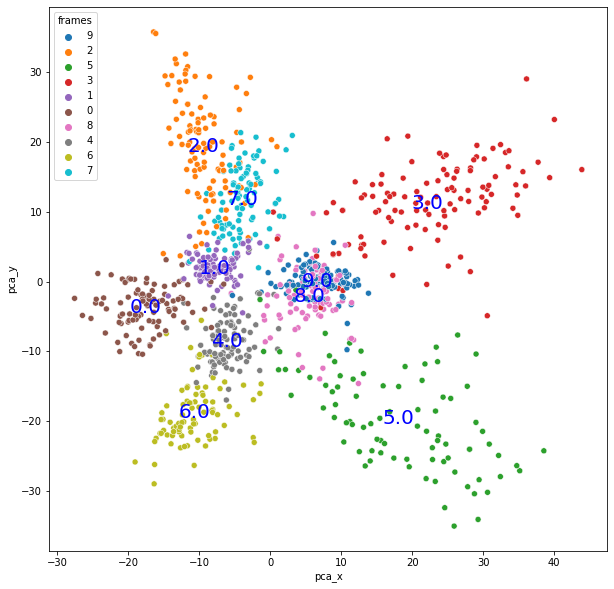

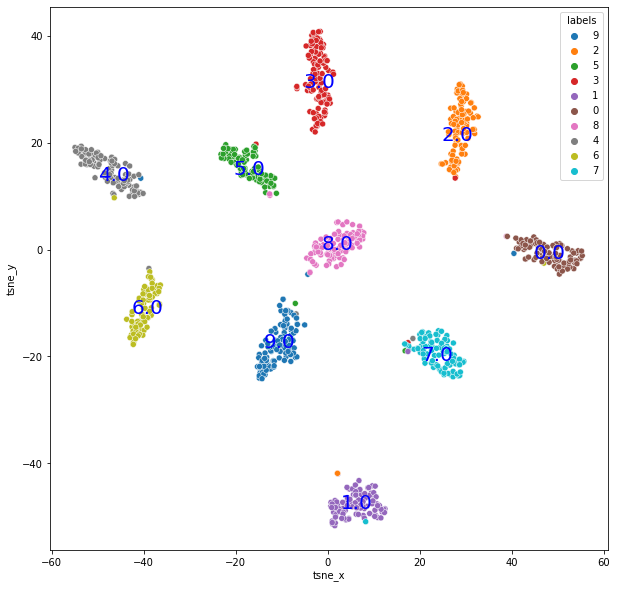

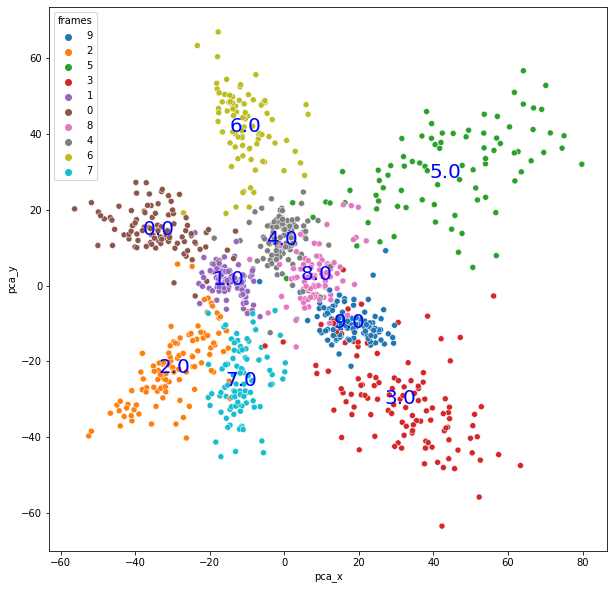

In [ ]:
for i in range(2,5):
  hide = final_res["hide"+str(i)]
  hide_main = hide[selected,:].detach().cpu().numpy()

  tsne(hide_main, 1024)
  pca(hide_main, 1024)


**Reasoning**: Compared to PCA, clustering is done properly in t-SNE as we run all the mentioned layers. But in PCA, the clustering wasn't done properly over the next layers.

**Question 2**

In [ ]:
units2 = 512
output_22 = 10
class RegNet(nn.Module):
    def __init__(self,input1,input2):
        super(RegNet,self).__init__()
        self.input = nn.Linear(input1*input2, units2)
        self.hide1 = nn.Linear(units2, units2)
        self.hide2 = nn.Linear(units2, units2)
        self.hide3 = nn.Linear(units2, units2)
        self.hide4 = nn.Linear(units2, units2)
        #self.hide5 = nn.Linear(units2, units2)
        self.output = nn.Linear(units2, output_22)
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()
                
    def forward(self, network, function):
        if function == "relu":
          network = self.input(network)
          network = self.relu(network)      
          network = self.hide1(network)
          network = self.relu(network)
          network = self.hide2(network)
          network = self.relu(network)
          network = self.hide3(network)
          network = self.relu(network)
          network = self.hide4(network)
          network = self.relu(network)
          #network = self.hide5(network)
          #network = self.relu(network)         
          network = self.output(network)
          return network

        else:
          network = self.input(network)
          network = self.sigmoid(network)      
          network = self.hide1(network)
          network = self.sigmoid(network)
          network = self.hide2(network)
          network = self.sigmoid(network)
          network = self.hide3(network)
          network = self.sigmoid(network)
          network = self.hide4(network)
          network = self.sigmoid(network)
          #network = self.hide5(network)
          #network = self.sigmoid(network)         
          network = self.output(network)
          return network

model2 = RegNet(input1, input2).to(dev)
activation = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model2.parameters(), lr = 0.001)

In [ ]:
#stackoverflow
def weight_base(model):
    if isinstance(model, nn.Linear):
        weight = torch.empty(input1*input2, 1)
        torch.nn.init.normal_(model.weight, mean=0.0, std=0.01)
        #model.bias.data.fill_(0)
        #model.bias.data.fill_(0.01)


def weight_xavier(model):
    if isinstance(model, nn.Linear):
        weight = torch.empty(input1*input2, 1)
        torch.nn.init.xavier_normal_(model.weight)
        #model.bias.data.fill_(0)
        #model.bias.data.fill_(0.01)


def weight_kaiming(model):
    if isinstance(model, nn.Linear):
        weight = torch.empty(input1*input2, 1)
        torch.nn.init.kaiming_normal_(model.weight, a=0, nonlinearity='relu', mode='fan_in')
        #model.bias.data.fill_(0)
        #model.bias.data.fill_(0.01)


def train_neural_network(model,train_dataset,test_dataset,epochs,batch_size,
                         lr,verbose,activation,assess,input1,input2,dev,optimizer_1,function):
  
  perf = []
  test_len = len(test_dataset)
  initial=1
  stop=0
  top = 0
  rounds = 0
  stop = False

  train_iterate = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  test_iterate = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_len, shuffle=True)
  
  final_output = dict()
  
  if optimizer_1 == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  
  while ((initial <= epochs)and(stop==False)):
    for img, label in train_iterate:  
      img_reshape = img.reshape(-1,input1*input2).to(dev)
      label = label.to(dev)
      output_img = model(img_reshape, function)
      loss = activation(output_img, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      test_img,test_label = next(iter(test_iterate))
      test_img_reshape = test_img.reshape(-1, input1*input2).to(dev)
      test_label_accuracy = model.forward(test_img_reshape, function).argmax(1).cpu().numpy()
      accuracy = assess(test_label.numpy(),test_label_accuracy)
      perf.append(accuracy)

    if(accuracy > top):
      top = accuracy
      best_prediction = test_label_accuracy
      best_state_dict = model.state_dict()
      final_output["train_iterate"] = train_iterate
      final_output["test_img"] = test_img
      final_output["test_label"] = test_label
      final_output["model"] = model
      final_output["best_prediction"] = best_prediction
      final_output["top"] = top
      torch.save(model, 'top_mnist.pt')
    else:
      pass

    if(((initial%5==0)| verbose==True)):
      print("Current_epoch:"+str(initial))
      print('Accuracy: '+str(accuracy))
    initial += 1
  
  return (final_output), perf

In [ ]:
from sklearn.metrics import accuracy_score

def arch(optimizer_1, weight, function):
  batch_size = 64
  lr = 0.01
  epochs = 50
  model1 = RegNet(input1, input2).to(dev)
  if weight == "normal":
    model1.apply(weight_base)
  elif weight == "xavier":
    model1.apply(weight_xavier)
  else:
    model1.apply(weight_kaiming)
  final_output, perf = train_neural_network(model=model1, train_dataset=mnist_train, test_dataset=mnist_test, optimizer_1 = optimizer_1, epochs=epochs, activation=nn.CrossEntropyLoss(), batch_size=batch_size, lr=lr, verbose=True, assess=accuracy_score,
                input1=input1,
                input2=input2,
                function = function,
                dev=dev)

  train_iterate = final_output["train_iterate"] 
  test_img = final_output["test_img"] 
  test_label = final_output["test_label"]
  best_model = final_output["model"] 
  test_label_accuracy = final_output["best_prediction"]

  return perf

In [ ]:
adam_net1 = arch("Adam", "normal", "sigmoid")

Current_epoch:1
Accuracy: 0.4643
Current_epoch:2
Accuracy: 0.8375
Current_epoch:3
Accuracy: 0.9492
Current_epoch:4
Accuracy: 0.951
Current_epoch:5
Accuracy: 0.9686
Current_epoch:6
Accuracy: 0.9716
Current_epoch:7
Accuracy: 0.9662
Current_epoch:8
Accuracy: 0.969
Current_epoch:9
Accuracy: 0.9718
Current_epoch:10
Accuracy: 0.9743
Current_epoch:11
Accuracy: 0.9763
Current_epoch:12
Accuracy: 0.974
Current_epoch:13
Accuracy: 0.9767
Current_epoch:14
Accuracy: 0.9763
Current_epoch:15
Accuracy: 0.968
Current_epoch:16
Accuracy: 0.9741
Current_epoch:17
Accuracy: 0.9762
Current_epoch:18
Accuracy: 0.9795
Current_epoch:19
Accuracy: 0.976
Current_epoch:20
Accuracy: 0.9731
Current_epoch:21
Accuracy: 0.9789
Current_epoch:22
Accuracy: 0.9736
Current_epoch:23
Accuracy: 0.9806
Current_epoch:24
Accuracy: 0.9783
Current_epoch:25
Accuracy: 0.9814
Current_epoch:26
Accuracy: 0.9779
Current_epoch:27
Accuracy: 0.9762
Current_epoch:28
Accuracy: 0.9773
Current_epoch:29
Accuracy: 0.9798
Current_epoch:30
Accuracy: 0

In [ ]:
adam_net2 = arch("Adam", "xavier", "sigmoid")

Current_epoch:1
Accuracy: 0.9522
Current_epoch:2
Accuracy: 0.9661
Current_epoch:3
Accuracy: 0.9697
Current_epoch:4
Accuracy: 0.9713
Current_epoch:5
Accuracy: 0.9714
Current_epoch:6
Accuracy: 0.9749
Current_epoch:7
Accuracy: 0.9734
Current_epoch:8
Accuracy: 0.9782
Current_epoch:9
Accuracy: 0.9771
Current_epoch:10
Accuracy: 0.9745
Current_epoch:11
Accuracy: 0.9775
Current_epoch:12
Accuracy: 0.9808
Current_epoch:13
Accuracy: 0.9774
Current_epoch:14
Accuracy: 0.9705
Current_epoch:15
Accuracy: 0.9814
Current_epoch:16
Accuracy: 0.9808
Current_epoch:17
Accuracy: 0.9774
Current_epoch:18
Accuracy: 0.9746
Current_epoch:19
Accuracy: 0.9794
Current_epoch:20
Accuracy: 0.9774
Current_epoch:21
Accuracy: 0.9756
Current_epoch:22
Accuracy: 0.9815
Current_epoch:23
Accuracy: 0.979
Current_epoch:24
Accuracy: 0.9785
Current_epoch:25
Accuracy: 0.9776
Current_epoch:26
Accuracy: 0.9771
Current_epoch:27
Accuracy: 0.9812
Current_epoch:28
Accuracy: 0.9751
Current_epoch:29
Accuracy: 0.9798
Current_epoch:30
Accurac

In [ ]:
adam_net3 = arch("Adam", "normal", "relu")

Current_epoch:1
Accuracy: 0.9498
Current_epoch:2
Accuracy: 0.9617
Current_epoch:3
Accuracy: 0.9641
Current_epoch:4
Accuracy: 0.9717
Current_epoch:5
Accuracy: 0.973
Current_epoch:6
Accuracy: 0.976
Current_epoch:7
Accuracy: 0.9764
Current_epoch:8
Accuracy: 0.9765
Current_epoch:9
Accuracy: 0.9777
Current_epoch:10
Accuracy: 0.9789
Current_epoch:11
Accuracy: 0.9818
Current_epoch:12
Accuracy: 0.9797
Current_epoch:13
Accuracy: 0.9797
Current_epoch:14
Accuracy: 0.9807
Current_epoch:15
Accuracy: 0.9794
Current_epoch:16
Accuracy: 0.9802
Current_epoch:17
Accuracy: 0.9835
Current_epoch:18
Accuracy: 0.9823
Current_epoch:19
Accuracy: 0.9776
Current_epoch:20
Accuracy: 0.9819
Current_epoch:21
Accuracy: 0.9807
Current_epoch:22
Accuracy: 0.9809
Current_epoch:23
Accuracy: 0.9825
Current_epoch:24
Accuracy: 0.979
Current_epoch:25
Accuracy: 0.9812
Current_epoch:26
Accuracy: 0.9817
Current_epoch:27
Accuracy: 0.9757
Current_epoch:28
Accuracy: 0.9827
Current_epoch:29
Accuracy: 0.9815
Current_epoch:30
Accuracy:

In [ ]:
adam_net4 = arch("Adam", "xavier", "relu")

Current_epoch:1
Accuracy: 0.9646
Current_epoch:2
Accuracy: 0.9691
Current_epoch:3
Accuracy: 0.9693
Current_epoch:4
Accuracy: 0.9755
Current_epoch:5
Accuracy: 0.9803
Current_epoch:6
Accuracy: 0.9763
Current_epoch:7
Accuracy: 0.9766
Current_epoch:8
Accuracy: 0.9748
Current_epoch:9
Accuracy: 0.9765
Current_epoch:10
Accuracy: 0.9765
Current_epoch:11
Accuracy: 0.978
Current_epoch:12
Accuracy: 0.98
Current_epoch:13
Accuracy: 0.9726
Current_epoch:14
Accuracy: 0.9783
Current_epoch:15
Accuracy: 0.9826
Current_epoch:16
Accuracy: 0.9769
Current_epoch:17
Accuracy: 0.9754
Current_epoch:18
Accuracy: 0.978
Current_epoch:19
Accuracy: 0.9792
Current_epoch:20
Accuracy: 0.9778
Current_epoch:21
Accuracy: 0.9825
Current_epoch:22
Accuracy: 0.9812
Current_epoch:23
Accuracy: 0.9726
Current_epoch:24
Accuracy: 0.9794
Current_epoch:25
Accuracy: 0.9808
Current_epoch:26
Accuracy: 0.9787
Current_epoch:27
Accuracy: 0.978
Current_epoch:28
Accuracy: 0.9818
Current_epoch:29
Accuracy: 0.9817
Current_epoch:30
Accuracy: 0

In [ ]:
adam_net5 = arch("Adam", "kaiming", "relu")

Current_epoch:1
Accuracy: 0.9643
Current_epoch:2
Accuracy: 0.9696
Current_epoch:3
Accuracy: 0.9707
Current_epoch:4
Accuracy: 0.9713
Current_epoch:5
Accuracy: 0.9788
Current_epoch:6
Accuracy: 0.9742
Current_epoch:7
Accuracy: 0.9767
Current_epoch:8
Accuracy: 0.9765
Current_epoch:9
Accuracy: 0.9799
Current_epoch:10
Accuracy: 0.9785
Current_epoch:11
Accuracy: 0.9778
Current_epoch:12
Accuracy: 0.9776
Current_epoch:13
Accuracy: 0.9782
Current_epoch:14
Accuracy: 0.9723
Current_epoch:15
Accuracy: 0.9799
Current_epoch:16
Accuracy: 0.9759
Current_epoch:17
Accuracy: 0.978
Current_epoch:18
Accuracy: 0.9801
Current_epoch:19
Accuracy: 0.9778
Current_epoch:20
Accuracy: 0.9737
Current_epoch:21
Accuracy: 0.9815
Current_epoch:22
Accuracy: 0.9787
Current_epoch:23
Accuracy: 0.9795
Current_epoch:24
Accuracy: 0.9786
Current_epoch:25
Accuracy: 0.9815
Current_epoch:26
Accuracy: 0.9741
Current_epoch:27
Accuracy: 0.9779
Current_epoch:28
Accuracy: 0.9833
Current_epoch:29
Accuracy: 0.9814
Current_epoch:30
Accurac

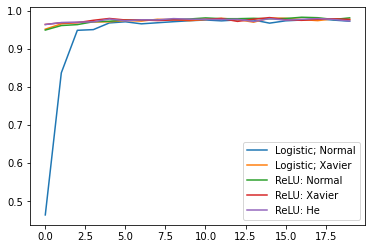

In [ ]:
plt.plot(adam_net1[:20], label="Logistic; Normal")
plt.plot(adam_net2[:20], label="Logistic; Xavier")
plt.plot(adam_net3[:20], label="ReLU: Normal")
plt.plot(adam_net4[:20], label="ReLU: Xavier")
plt.plot(adam_net5[:20], label="ReLU: He")
plt.legend()
plt.show()

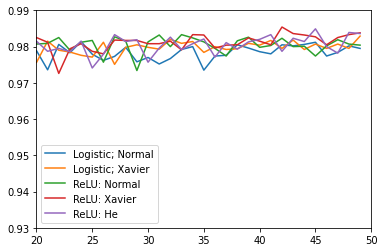

In [ ]:
plt.plot(adam_net1, label="Logistic; Normal")
plt.plot(adam_net2, label="Logistic; Xavier")
plt.plot(adam_net3, label="ReLU: Normal")
plt.plot(adam_net4, label="ReLU: Xavier")
plt.plot(adam_net5, label="ReLU: He")
plt.legend()
plt.xlim([20, 50])
plt.ylim([0.93, 0.99])
plt.show()

In [ ]:
sgd_net1 = arch("SGD", "normal", "sigmoid")

Current_epoch:1
Accuracy: 0.1009
Current_epoch:2
Accuracy: 0.101
Current_epoch:3
Accuracy: 0.1135
Current_epoch:4
Accuracy: 0.1135
Current_epoch:5
Accuracy: 0.1028
Current_epoch:6
Accuracy: 0.0958
Current_epoch:7
Accuracy: 0.098
Current_epoch:8
Accuracy: 0.101
Current_epoch:9
Accuracy: 0.1135
Current_epoch:10
Accuracy: 0.1135
Current_epoch:11
Accuracy: 0.1032
Current_epoch:12
Accuracy: 0.1135
Current_epoch:13
Accuracy: 0.1135
Current_epoch:14
Accuracy: 0.101
Current_epoch:15
Accuracy: 0.0974
Current_epoch:16
Accuracy: 0.1135
Current_epoch:17
Accuracy: 0.1135
Current_epoch:18
Accuracy: 0.1135
Current_epoch:19
Accuracy: 0.101
Current_epoch:20
Accuracy: 0.1135
Current_epoch:21
Accuracy: 0.1135
Current_epoch:22
Accuracy: 0.1135
Current_epoch:23
Accuracy: 0.1135
Current_epoch:24
Accuracy: 0.1135
Current_epoch:25
Accuracy: 0.1032
Current_epoch:26
Accuracy: 0.1135
Current_epoch:27
Accuracy: 0.101
Current_epoch:28
Accuracy: 0.1028
Current_epoch:29
Accuracy: 0.1028
Current_epoch:30
Accuracy: 0.

In [ ]:
sgd_net2 = arch("SGD", "xavier", "sigmoid")

Current_epoch:1
Accuracy: 0.0974
Current_epoch:2
Accuracy: 0.1028
Current_epoch:3
Accuracy: 0.1828
Current_epoch:4
Accuracy: 0.0974
Current_epoch:5
Accuracy: 0.0982
Current_epoch:6
Accuracy: 0.1135
Current_epoch:7
Accuracy: 0.0892
Current_epoch:8
Accuracy: 0.0982
Current_epoch:9
Accuracy: 0.1032
Current_epoch:10
Accuracy: 0.1135
Current_epoch:11
Accuracy: 0.1028
Current_epoch:12
Accuracy: 0.2076
Current_epoch:13
Accuracy: 0.0958
Current_epoch:14
Accuracy: 0.098
Current_epoch:15
Accuracy: 0.1542
Current_epoch:16
Accuracy: 0.0982
Current_epoch:17
Accuracy: 0.1366
Current_epoch:18
Accuracy: 0.1143
Current_epoch:19
Accuracy: 0.0958
Current_epoch:20
Accuracy: 0.1864
Current_epoch:21
Accuracy: 0.332
Current_epoch:22
Accuracy: 0.2979
Current_epoch:23
Accuracy: 0.3013
Current_epoch:24
Accuracy: 0.3445
Current_epoch:25
Accuracy: 0.3781
Current_epoch:26
Accuracy: 0.4092
Current_epoch:27
Accuracy: 0.4592
Current_epoch:28
Accuracy: 0.5234
Current_epoch:29
Accuracy: 0.61
Current_epoch:30
Accuracy: 

In [ ]:
sgd_net3 = arch("SGD", "normal", "relu")

Current_epoch:1
Accuracy: 0.1135
Current_epoch:2
Accuracy: 0.1135
Current_epoch:3
Accuracy: 0.1135
Current_epoch:4
Accuracy: 0.1135
Current_epoch:5
Accuracy: 0.1135
Current_epoch:6
Accuracy: 0.1135
Current_epoch:7
Accuracy: 0.1135
Current_epoch:8
Accuracy: 0.1135
Current_epoch:9
Accuracy: 0.1135
Current_epoch:10
Accuracy: 0.1135
Current_epoch:11
Accuracy: 0.1135
Current_epoch:12
Accuracy: 0.1135
Current_epoch:13
Accuracy: 0.1135
Current_epoch:14
Accuracy: 0.1135
Current_epoch:15
Accuracy: 0.1135
Current_epoch:16
Accuracy: 0.1135
Current_epoch:17
Accuracy: 0.1135
Current_epoch:18
Accuracy: 0.1135
Current_epoch:19
Accuracy: 0.1135
Current_epoch:20
Accuracy: 0.1135
Current_epoch:21
Accuracy: 0.1135
Current_epoch:22
Accuracy: 0.1135
Current_epoch:23
Accuracy: 0.1135
Current_epoch:24
Accuracy: 0.1135
Current_epoch:25
Accuracy: 0.1135
Current_epoch:26
Accuracy: 0.1135
Current_epoch:27
Accuracy: 0.1135
Current_epoch:28
Accuracy: 0.1135
Current_epoch:29
Accuracy: 0.1135
Current_epoch:30
Accura

In [ ]:
sgd_net4 = arch("SGD", "xavier", "relu")

Current_epoch:1
Accuracy: 0.9284
Current_epoch:2
Accuracy: 0.9434
Current_epoch:3
Accuracy: 0.9578
Current_epoch:4
Accuracy: 0.962
Current_epoch:5
Accuracy: 0.9675
Current_epoch:6
Accuracy: 0.9707
Current_epoch:7
Accuracy: 0.9722
Current_epoch:8
Accuracy: 0.9737
Current_epoch:9
Accuracy: 0.9736
Current_epoch:10
Accuracy: 0.9756
Current_epoch:11
Accuracy: 0.9755
Current_epoch:12
Accuracy: 0.9752
Current_epoch:13
Accuracy: 0.9757
Current_epoch:14
Accuracy: 0.9729
Current_epoch:15
Accuracy: 0.9772
Current_epoch:16
Accuracy: 0.9687
Current_epoch:17
Accuracy: 0.9772
Current_epoch:18
Accuracy: 0.9766
Current_epoch:19
Accuracy: 0.9776
Current_epoch:20
Accuracy: 0.978
Current_epoch:21
Accuracy: 0.9785
Current_epoch:22
Accuracy: 0.978
Current_epoch:23
Accuracy: 0.9781
Current_epoch:24
Accuracy: 0.9786
Current_epoch:25
Accuracy: 0.979
Current_epoch:26
Accuracy: 0.9781
Current_epoch:27
Accuracy: 0.9789
Current_epoch:28
Accuracy: 0.9798
Current_epoch:29
Accuracy: 0.979
Current_epoch:30
Accuracy: 0

In [ ]:
sgd_net5 = arch("SGD", "kaiming", "relu")

Current_epoch:1
Accuracy: 0.9475
Current_epoch:2
Accuracy: 0.959
Current_epoch:3
Accuracy: 0.9627
Current_epoch:4
Accuracy: 0.971
Current_epoch:5
Accuracy: 0.9725
Current_epoch:6
Accuracy: 0.9697
Current_epoch:7
Accuracy: 0.9691
Current_epoch:8
Accuracy: 0.9699
Current_epoch:9
Accuracy: 0.975
Current_epoch:10
Accuracy: 0.9661
Current_epoch:11
Accuracy: 0.9768
Current_epoch:12
Accuracy: 0.976
Current_epoch:13
Accuracy: 0.9769
Current_epoch:14
Accuracy: 0.9772
Current_epoch:15
Accuracy: 0.9766
Current_epoch:16
Accuracy: 0.9777
Current_epoch:17
Accuracy: 0.9774
Current_epoch:18
Accuracy: 0.978
Current_epoch:19
Accuracy: 0.9782
Current_epoch:20
Accuracy: 0.9778
Current_epoch:21
Accuracy: 0.9784
Current_epoch:22
Accuracy: 0.9782
Current_epoch:23
Accuracy: 0.9781
Current_epoch:24
Accuracy: 0.9779
Current_epoch:25
Accuracy: 0.9781
Current_epoch:26
Accuracy: 0.9784
Current_epoch:27
Accuracy: 0.9781
Current_epoch:28
Accuracy: 0.9785
Current_epoch:29
Accuracy: 0.9783
Current_epoch:30
Accuracy: 0

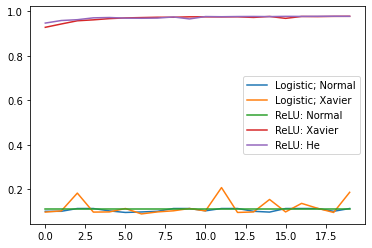

In [ ]:
plt.plot(sgd_net1[:20], label="Logistic; Normal")
plt.plot(sgd_net2[:20], label="Logistic; Xavier")
plt.plot(sgd_net3[:20], label="ReLU: Normal")
plt.plot(sgd_net4[:20], label="ReLU: Xavier")
plt.plot(sgd_net5[:20], label="ReLU: He")
plt.legend()
plt.show()

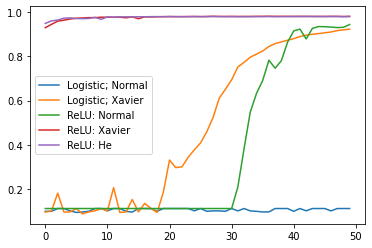

In [ ]:
plt.plot(sgd_net1, label="Logistic; Normal")
plt.plot(sgd_net2, label="Logistic; Xavier")
plt.plot(sgd_net3, label="ReLU: Normal")
plt.plot(sgd_net4, label="ReLU: Xavier")
plt.plot(sgd_net5, label="ReLU: He")
plt.legend()
#plt.xlim([50, 187])
#plt.ylim([0.00, 0.99])
plt.show()

**Question 3**

In [39]:
units = 1024
output3 = 10
class RegNet(nn.Module):
    def __init__(self,input1,input2,dropout_value=0.0):
        super(RegNet,self).__init__()
        self.input = nn.Linear(input1*input2, units)
        self.hide1 = nn.Linear(units, units)
        self.hide2 = nn.Linear(units, units)
        self.hide3 = nn.Linear(units, units)
        self.hide4 = nn.Linear(units, units)
        #self.hide5 = nn.Linear(units, units)
        self.output = nn.Linear(units, output3)
        #self.dropout_init = nn.Dropout(dropout_value)
        self.dropout_init2 = nn.Dropout(p = 0.2)
        self.dropout_init5 = nn.Dropout(p = 0.5)
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()
                
    def forward(self, network, function, dropout_value):
        if function == "relu":
          activation = self.relu(network)
        else:
          activation = self.sigmoid(network)
        if dropout_value == "no":
          network = self.input(network)
          network = self.relu(network)
          #network = self.dropout_init(network)
          network = self.hide1(network)
          network = self.relu(network)
          #network = self.dropout_init(network)
          network = self.hide2(network)
          network = self.relu(network)
          #network = self.dropout_init(network)
          network = self.hide3(network)
          network = self.relu(network)
          #network = self.dropout_init(network)
          network = self.hide4(network)
          network = self.relu(network)
          #network = self.dropout_init(network)
          #network = self.hide5(network)
          #network = self.relu(network)
          #network = self.dropout_init(network)         
          network = self.output(network)
          return network

        else:
          network = self.input(network)
          network = self.relu(network)
          network = self.dropout_init2(network)
          network = self.hide1(network)
          network = self.relu(network)
          network = self.dropout_init5(network)
          network = self.hide2(network)
          network = self.relu(network)
          network = self.dropout_init5(network)
          network = self.hide3(network)
          network = self.relu(network)
          network = self.dropout_init5(network)
          network = self.hide4(network)
          network = self.relu(network)
          network = self.dropout_init5(network)
          #network = self.hide5(network)
          #network = self.relu(network)
          #network = self.dropout_init5(network)
          network = self.output(network)
          return network

In [40]:
def weight_base(model):
    if isinstance(model, nn.Linear):
        weight = torch.empty(input1*input2, 1)
        torch.nn.init.normal_(model.weight, mean=0.0, std=0.01)

def weight_xavier(model):
    if isinstance(model, nn.Linear):
        weight = torch.empty(input1*input2, 1)
        torch.nn.init.xavier_normal_(model.weight)
        #model.bias.data.fill_(0.01)

def weight_kaiming(model):
    if isinstance(model, nn.Linear):
        weight = torch.empty(input1*input2, 1)
        torch.nn.init.kaiming_normal_(model.weight, a=0, nonlinearity='relu', mode='fan_in',)

def train_neural_network(model,train_dataset,test_dataset,epochs,batch_size,
                         lr,verbose,activation,assess,input1,input2,dev,dropout_value,function):
  
  initial=1
  stop=0
  top = 0
  rounds = 0
  stop = False
  train_1= []
  test_1 = []
  #n_train = len(train_dataset)
  test_len = len(test_dataset)

  train_iterate = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  test_iterate = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_len, shuffle=True)
  
  final_output = dict()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  
  while ((initial <= epochs)and(stop==False)):
    test_init = 0
    train_loss = 0
    for img, label in train_iterate:
      img_reshape = img.reshape(-1,input1*input2).to(dev)
      label = label.to(dev)
      output_img = model(img_reshape, function, dropout_value)
      loss = activation(output_img, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      # train_1.append(train_loss)
      
    train_1.append(train_loss/len(train_iterate))

    for test_img, test_label in test_iterate:
      test_img_reshape = test_img.reshape(-1,input1*input2).to(dev)
      test_label = test_label.to(dev)
      test_output_img = model(test_img_reshape, function, dropout_value)
      test_act = activation(test_output_img, test_label)
      optimizer.zero_grad()
      test_act.backward()
      optimizer.step()

      test_init += test_act.item()
      # test_1.append(test_init)

    test_1.append(test_init/len(test_iterate))

    if(((initial%5==0)| verbose==True)):
      print("Current_epoch:"+str(initial))
      #print('Accuracy: '+str(accuracy))

    initial += 1
  
  return train_1, test_1

In [41]:
from sklearn.metrics import accuracy_score

def arch(weight, function, dropout_value):
  #without_drop = 32 with_drop = 3000
  #batch_size = 512
  epochs = 200
  #d = 0.2
  lr = 0.001

  if dropout_value == "no":
    batch_size = 32
  else:
    batch_size = 3000

  model3 = RegNet(input1, input2, dropout_value).to(dev)
  if weight == "normal":
    model3.apply(weight_base)
  elif weight == "xavier":
    model3.apply(weight_xavier)
  else:
    model3.apply(weight_kaiming)

  train_1, test_1 = train_neural_network(model=model3, train_dataset=mnist_train, test_dataset=mnist_test, epochs=epochs, activation=nn.CrossEntropyLoss(), batch_size=batch_size, lr=lr, verbose=True, assess=accuracy_score,
                input1=input1, input2=input2, function = function,
                dev=dev,
                dropout_value = dropout_value)
  
  return train_1, test_1

In [42]:
train_net1, test_net1 = arch("xavier", "sigmoid", "no")

Current_epoch:1
Current_epoch:2
Current_epoch:3
Current_epoch:4
Current_epoch:5
Current_epoch:6
Current_epoch:7
Current_epoch:8
Current_epoch:9
Current_epoch:10
Current_epoch:11
Current_epoch:12
Current_epoch:13
Current_epoch:14
Current_epoch:15
Current_epoch:16
Current_epoch:17
Current_epoch:18
Current_epoch:19
Current_epoch:20
Current_epoch:21
Current_epoch:22
Current_epoch:23
Current_epoch:24
Current_epoch:25
Current_epoch:26
Current_epoch:27
Current_epoch:28
Current_epoch:29
Current_epoch:30
Current_epoch:31
Current_epoch:32
Current_epoch:33
Current_epoch:34
Current_epoch:35
Current_epoch:36
Current_epoch:37
Current_epoch:38
Current_epoch:39
Current_epoch:40
Current_epoch:41
Current_epoch:42
Current_epoch:43
Current_epoch:44
Current_epoch:45
Current_epoch:46
Current_epoch:47
Current_epoch:48
Current_epoch:49
Current_epoch:50
Current_epoch:51
Current_epoch:52
Current_epoch:53
Current_epoch:54
Current_epoch:55
Current_epoch:56
Current_epoch:57
Current_epoch:58
Current_epoch:59
Curren

In [43]:
train_net2, test_net2 = arch("xavier", "sigmoid", "yes")

Current_epoch:1
Current_epoch:2
Current_epoch:3
Current_epoch:4
Current_epoch:5
Current_epoch:6
Current_epoch:7
Current_epoch:8
Current_epoch:9
Current_epoch:10
Current_epoch:11
Current_epoch:12
Current_epoch:13
Current_epoch:14
Current_epoch:15
Current_epoch:16
Current_epoch:17
Current_epoch:18
Current_epoch:19
Current_epoch:20
Current_epoch:21
Current_epoch:22
Current_epoch:23
Current_epoch:24
Current_epoch:25
Current_epoch:26
Current_epoch:27
Current_epoch:28
Current_epoch:29
Current_epoch:30
Current_epoch:31
Current_epoch:32
Current_epoch:33
Current_epoch:34
Current_epoch:35
Current_epoch:36
Current_epoch:37
Current_epoch:38
Current_epoch:39
Current_epoch:40
Current_epoch:41
Current_epoch:42
Current_epoch:43
Current_epoch:44
Current_epoch:45
Current_epoch:46
Current_epoch:47
Current_epoch:48
Current_epoch:49
Current_epoch:50
Current_epoch:51
Current_epoch:52
Current_epoch:53
Current_epoch:54
Current_epoch:55
Current_epoch:56
Current_epoch:57
Current_epoch:58
Current_epoch:59
Curren

Sigmoid


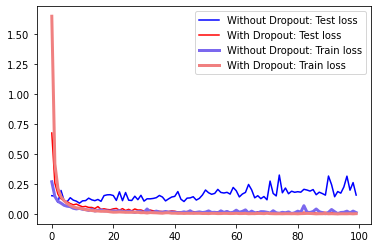

In [46]:
plt.plot(test_net1[:100], label="Without Dropout: Test loss", color = "blue")
plt.plot(test_net2[:100], label="With Dropout: Test loss", color = "red")
plt.plot(train_net1[:100], label="Without Dropout: Train loss", linewidth=3, color = "mediumslateblue")
plt.plot(train_net2[:100], label="With Dropout: Train loss", linewidth=3, color = "lightcoral")
print("Sigmoid")
plt.legend()
plt.show()

In [47]:
train_net3, test_net3 = arch("kaiming","relu", "no")

Current_epoch:1
Current_epoch:2
Current_epoch:3
Current_epoch:4
Current_epoch:5
Current_epoch:6
Current_epoch:7
Current_epoch:8
Current_epoch:9
Current_epoch:10
Current_epoch:11
Current_epoch:12
Current_epoch:13
Current_epoch:14
Current_epoch:15
Current_epoch:16
Current_epoch:17
Current_epoch:18
Current_epoch:19
Current_epoch:20
Current_epoch:21
Current_epoch:22
Current_epoch:23
Current_epoch:24
Current_epoch:25
Current_epoch:26
Current_epoch:27
Current_epoch:28
Current_epoch:29
Current_epoch:30
Current_epoch:31
Current_epoch:32
Current_epoch:33
Current_epoch:34
Current_epoch:35
Current_epoch:36
Current_epoch:37
Current_epoch:38
Current_epoch:39
Current_epoch:40
Current_epoch:41
Current_epoch:42
Current_epoch:43
Current_epoch:44
Current_epoch:45
Current_epoch:46
Current_epoch:47
Current_epoch:48
Current_epoch:49
Current_epoch:50
Current_epoch:51
Current_epoch:52
Current_epoch:53
Current_epoch:54
Current_epoch:55
Current_epoch:56
Current_epoch:57
Current_epoch:58
Current_epoch:59
Curren

In [48]:
train_net4, test_net4 = arch("kaiming", "relu", "yes")

Current_epoch:1
Current_epoch:2
Current_epoch:3
Current_epoch:4
Current_epoch:5
Current_epoch:6
Current_epoch:7
Current_epoch:8
Current_epoch:9
Current_epoch:10
Current_epoch:11
Current_epoch:12
Current_epoch:13
Current_epoch:14
Current_epoch:15
Current_epoch:16
Current_epoch:17
Current_epoch:18
Current_epoch:19
Current_epoch:20
Current_epoch:21
Current_epoch:22
Current_epoch:23
Current_epoch:24
Current_epoch:25
Current_epoch:26
Current_epoch:27
Current_epoch:28
Current_epoch:29
Current_epoch:30
Current_epoch:31
Current_epoch:32
Current_epoch:33
Current_epoch:34
Current_epoch:35
Current_epoch:36
Current_epoch:37
Current_epoch:38
Current_epoch:39
Current_epoch:40
Current_epoch:41
Current_epoch:42
Current_epoch:43
Current_epoch:44
Current_epoch:45
Current_epoch:46
Current_epoch:47
Current_epoch:48
Current_epoch:49
Current_epoch:50
Current_epoch:51
Current_epoch:52
Current_epoch:53
Current_epoch:54
Current_epoch:55
Current_epoch:56
Current_epoch:57
Current_epoch:58
Current_epoch:59
Curren

ReLU


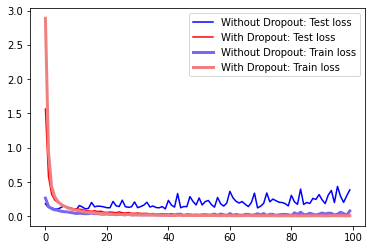

In [52]:
plt.plot(test_net3[:100], label="Without Dropout: Test loss", color = "blue")
plt.plot(test_net4[:100], label="With Dropout: Test loss", color = "red")
plt.plot(train_net3[:100], label="Without Dropout: Train loss", linewidth=3, color = "mediumslateblue")
plt.plot(train_net4[:100], label="With Dropout: Train loss", linewidth=3, color = "lightcoral")
print("ReLU")
plt.legend()
plt.show()